## Замечание

Коды рассчитываются старым способом: происходит деление на 8 частей. Это необходимо поправить и заменить `np.atan()` на `np.atan2()`

In [1]:
from tqdm import tqdm
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
from Levenshtein import distance as levenstein

np.warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def convert(imgf, labelf, outf, n, size):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in tqdm(range(n), desc=outf):
        image = [ord(l.read(1))]
        for j in range(size[0]*size[1]):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()
    
def show_image(image, label=None, ax=plt):
    ax.imshow(image, cmap='gray');
    ax.title('Цифра:'+str('' if label is None else label))
    ax.axis('off');
    
def show_image_data_frame(df, index, ax):
    ax.imshow(get_image(df, index)[1], cmap='gray');
    ax.title('Цифра:'+str(df.loc[index, 0]))
    ax.axis('off');
    
def get_image(df, index):
    return df.loc[index, 0], df.loc[index, 1:].values.reshape((28, 28)).astype(np.uint8)

def get_codes(image, count_directs=8, width_angle=np.pi/2, strength_threshould=0):
    sobel_x = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=1)
    sobel_y = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=1)
    
    start_angle = -np.pi/2
    
    residual_angle = np.pi - width_angle
    step_angle = residual_angle / (count_directs-1)
    
    gamma_down = np.arange(start_angle, start_angle+width_angle+step_angle, step_angle)
    gamma_up = gamma_down+width_angle
    
    angle = np.arctan(sobel_y / sobel_x)
    strength = np.sqrt(sobel_y** 2 + sobel_x ** 2)
    
    return np.array([
        np.uint((gamma_down[i] <= angle) & (angle <= gamma_up[i]) & (strength >= strength_threshould))
        for i in range(0, count_directs)
    ])

def get_codes_data_frame(image, count_directs=8, width_angle=np.pi/2, strength_threshould=0):
    sobel_x = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=1)
    sobel_y = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=1)
    
    start_angle = -np.pi/2
    
    residual_angle = np.pi - width_angle
    step_angle = residual_angle / (count_directs-1)
    
    gamma_down = np.arange(start_angle, start_angle+width_angle+step_angle, step_angle)
    gamma_up = gamma_down+width_angle
    
    angle = np.arctan(sobel_y / sobel_x)
    strength = np.sqrt(sobel_y** 2 + sobel_x ** 2)
    
    return np.array([
        np.uint((gamma_down[i] <= angle) & (angle <= gamma_up[i]) & (strength >= strength_threshould))
        for i in range(0, count_directs)
    ])

def resize_row_data_frame(row, input_size=(32, 32), output_size=(28, 28)):
    return cv2.resize(row.reshape(input_size).astype(np.uint8), output_size).ravel()

def rotate_image(image, alpha=0, scale=1, size=(28, 28)):
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), alpha, scale)
    return cv2.warpAffine(image, M, (cols, rows))
    
def rotate_row_data_frame(row, alpha=0, scale=1, size=(28, 28)):
    label, image = row[0], row[1:].values.reshape((28, 28)).astype(np.uint8)
    return np.hstack([[label], rotate_image(image, alpha, scale).ravel()])

def rotate_image_data_frame(df, index, alpha=0, scale=1, size=(28, 28)):
    label, image = get_image(df, index)
    return label, rotate_image(image, alpha, scale) 

def get_context_image(context_number, image):
    dx = context_number[1] * (-1)
    dy = context_number[0] * (-1)
    x_context_image = np.zeros(image.shape)
    context_image = np.zeros(image.shape)
    
    # Формируем изображение в новом контексте
    if dx < 0:
        x_context_image[:, :dx] = image[:, :dx]
    elif dx == 0:
        x_context_image = image
    else:
        x_context_image[:, dx:] = image[:, dx:]
    if dy < 0:
        context_image[:dy, :] = x_context_image[:dy, :]
    elif dy == 0:
        context_image = x_context_image
    else:
        context_image[dy:, :] = x_context_image[dy:, :]
        
    return np.uint8(context_image)

Зададим конфиг для изображений

In [3]:
path_mnist = 'data/MNIST/'
conf_test_mnist = {
    'imgf': path_mnist+'t10k-images.idx3-ubyte',
    'labelf': path_mnist+'t10k-labels.idx1-ubyte',
    'n': 10000,
    'outf': path_mnist+'mnist_test.csv',
    'size': (28, 28)
}
conf_train_mnist = {
    'imgf': path_mnist+'train-images.idx3-ubyte',
    'labelf': path_mnist+'train-labels.idx1-ubyte',
    'n': 60000,
    'outf': path_mnist+'mnist_train.csv',
    'size': (28, 28)
}

Загрузим изображения и отобразим внутренне представление

In [4]:
df = pd.read_csv(conf_train_mnist['outf'], header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Визуализируем несколько цифр

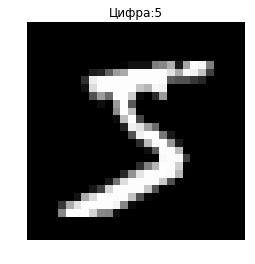

In [5]:
show_image_data_frame(df, 0, plt);

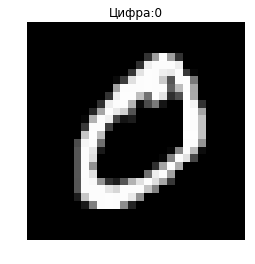

In [6]:
show_image_data_frame(df, 1, plt);

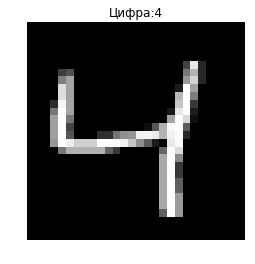

In [7]:
show_image_data_frame(df, 2, plt);

Наложем фильтр Собеля

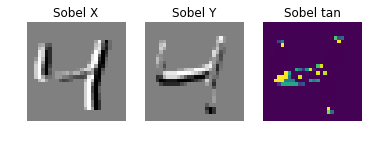

In [8]:
label, image = get_image(df, 2)
sobel_x = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=1)
sobel_y = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=1)
_, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(sobel_x, cmap='gray')
ax1.set_title('Sobel X')
ax1.axis('off')
ax2.imshow(sobel_y, cmap='gray')
ax2.set_title('Sobel Y')
ax2.axis('off')
ax3.imshow(np.uint8(np.divide(sobel_y+0.001, sobel_x+0.001)))
ax3.set_title('Sobel tan')
ax3.axis('off');

Посмотрим на распределение значений фильтра

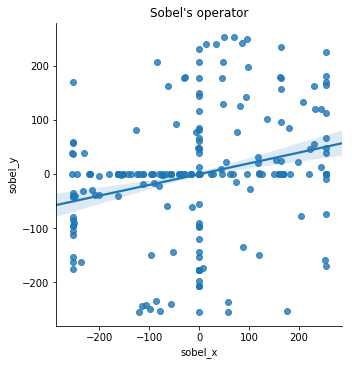

In [9]:
sns.lmplot(x='sobel_x', y='sobel_y', data=pd.DataFrame(np.transpose(np.array([sobel_x.flatten(), sobel_y.flatten()])), columns=['sobel_x', 'sobel_y']));
plt.title('Sobel\'s operator');

### Выбор контекста-победителя. Пример

Зададим начальные значения. Входное изображение; центр области, из которой требуется вырезать подизображение; размер изображения, которое будет преобразовано к другому контексту; номер контекста

In [10]:
image_number = 3
x0 = 12
y0 = 12
window_size = [4, 4]
context_number = [2, 1]

Преобразование изображения к новому контексту

In [11]:
label, image = get_image(df, image_number)
input_image = image[y0:y0+window_size[0], x0:x0+window_size[1]]
context_image = get_context_image(context_number=context_number, image=image[y0:y0+window_size[0], x0:x0+window_size[1]])

Входное изображение

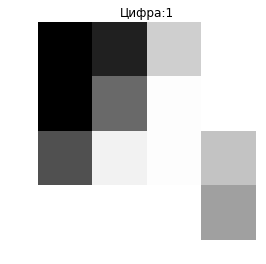

In [12]:
show_image(input_image, label, plt)

Изображение в новом контексте

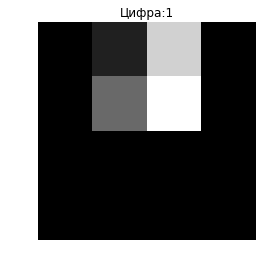

In [14]:
show_image(context_image, label, plt)

### Выбор контекста-победителя. Построение контекста-победителя

Пусть изображение из датасета под $№\ 4$, находящееся в точке $(12, 12)$ правым углом будет памятью. Будем брать все подизображения исходного изображения и получать его коды во всех контекстах. Для каждого такого подизображения будем находить контекст-победитель на основе сравнения кода в одном из контекстов с кодом из памяти.

Зададим начальные параметры:

In [15]:
image_number = 2
x0 = 12
y0 = 12
window_size = [4, 4]
label, image = get_image(df, image_number)

Создадим память

In [17]:
memory_image = image[y0:y0+window_size[0], x0:x0+window_size[1]]
memory_code = get_codes(memory_image)

Выберем подизображение, которое не пересекается с изображением из памяти

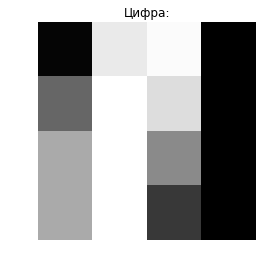

In [19]:
x_other = 17
y_other = 15
other_sub_image = image[y_other:y_other+window_size[0], x_other:x_other+window_size[1]]
show_image(other_sub_image)

Приведём его ко всем возможным контекстам и посчитаем скалярное произведение для кодов

In [20]:
context_codes = []
map_of_distance = []
for context_y in np.arange(-window_size[0]+1, window_size[1], 1):
    context_codes.append([])
    map_of_distance.append([])
    for context_x in np.arange(-window_size[1]+1, window_size[1], 1):
        context_number = [context_y, context_x]
        context_image = get_context_image(context_number=context_number, image=other_sub_image)
        context_code = get_codes(context_image)
        context_codes[-1].append(context_code)
        map_of_distance[-1].append(np.dot(context_code.flatten(), memory_code.flatten()))

Выведем матрицу значений со скалярными произведениями от памяти до всех возможных контекстов и значение скалярного произведения до контекста-победителя

Значение контекста-победителя: 26


,-3,-2,-1,0,1,2,3
-3,0,9,18,19,19,18,9
-2,0,13,23,22,22,22,13
-1,0,13,23,25,25,25,14
0,0,12,24,26,26,25,14
1,0,4,5,7,7,8,5
2,0,1,1,1,1,2,1
3,0,0,0,0,0,0,0


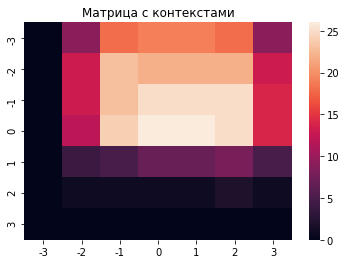

In [21]:
map_of_distance = pd.DataFrame(map_of_distance)
map_of_distance = map_of_distance.set_index(np.arange(-window_size[0]+1, window_size[1], 1))
map_of_distance.columns = np.arange(-window_size[0]+1, window_size[1], 1)
sns.heatmap(map_of_distance)
plt.title('Матрица с контекстами')
print('Значение контекста-победителя:', np.max(map_of_distance.as_matrix().flatten()))
map_of_distance

Выведем центрированное изображение

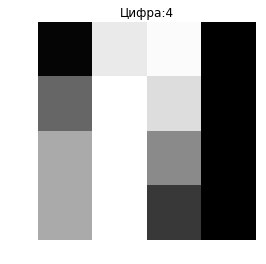

In [22]:
show_image(other_sub_image, label=label)

Выведем все изображения победители

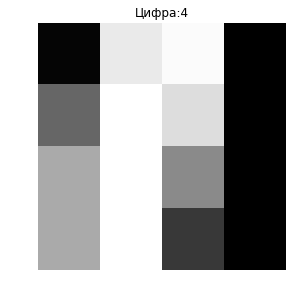

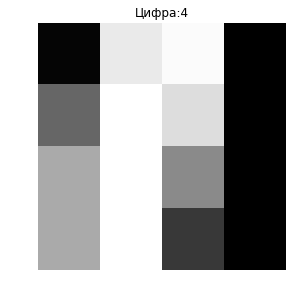

In [23]:
map_of_distance_matrix = map_of_distance.as_matrix()
context_y, context_x = np.where(map_of_distance_matrix == np.max(map_of_distance_matrix.flatten()))
context_y, context_x = context_y - (window_size[0] - 1), context_x - (window_size[1] - 1)
for context_num in range(len(context_x)):
    plt.figure(figsize=(5,5*len(context_x)))
    plt.subplot(len(context_x), 1, context_num+1);
    show_image(get_context_image(context_number=[context_y[context_num], context_x[context_num]], image=other_sub_image),
              label=label)